# Assignment Details

 Proposed scope of work
 <br>
 Fast fashion sales dictated by markdown periods
 <br>
 First use case: optimize margin during markdown
 <br>
 Side questions: are additional promotion during sales profitable?
 <br>
 Side question: how to share clients between VIP and super VIP
 <br>
 Many other side questions answered with the same tools…

## Retailer sanitized data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def load_hdf(filename):
    """
    Load the first key of an HDF file
    """
    hdf = pd.HDFStore(filename,mode = 'r')
    keys = hdf.keys()
    if not keys:
        hdf.close()
        return pd.DataFrame()
    data_df = hdf.get(keys[0])
    hdf.close()
    return data_df
    

## Load all files

In [3]:
PATH = '/Users/Oleg/Documents/Work/Essec_study/SBA/centrale_documents'

# CRM database
crm_df = load_hdf(os.path.join(PATH, 'crm.hd5'))

# Central stock
stock_dep_df = load_hdf(os.path.join(PATH, 'stock_dep.hd5'))

# Stores stock
stock_mag_df = load_hdf(os.path.join(PATH, 'stock_mag.hd5'))

# Product description
product_df = load_hdf(os.path.join(PATH, 'products.hd5'))

# Stores characteristic
stores_df = load_hdf(os.path.join(PATH, 'stores.hd5'))

# Transactions
transactions_df = load_hdf(os.path.join(PATH, 'transactions.hd5'))

## CRM

## 0. Original dataset modifications

In [3]:
### Get a preview of the dataset ###

In [4]:
crm_df.sample(n=4)

client_id_1     client_id_2 store_code            segmentation   age  \
1138628      2320221  286:0000024047       B148  Fidèle Occasionnelle +  54.0   
145134       2208494  CAR-0000131431       B000     Abandonniste Petite  68.0   
657556       2699997   72-0000001909       B107             Fidèle Mono  60.0   
24762        2218805  152:0000009057       B584             Fidèle Gold  46.0   

        postal_code  
1138628       92370  
145134        60250  
657556        87280  
24762         42100

There are some missing values for the age and postal_code variables 

In [5]:
### Number of stores ###

In [5]:
nb_stores = crm_df.store_code.unique()
nb_stores = np.size(nb_stores)
print(nb_stores)

397


In [7]:
### Number of clients ###

In [6]:
nb_clients = crm_df.client_id_1.count()
len(crm_df.client_id_1.unique())

1149866

In [7]:
print(nb_clients)

1149866


In [10]:
### Client IDs ###

In [8]:
# Number of client IDs (Client ID 1)
a = crm_df.client_id_1.unique()
print(np.size(a))

# Number of client IDs (Client ID 2)
b = crm_df.client_id_2.unique()
print(np.size(b))

1149866
1149866


In [12]:
### Customers segments ###

In [9]:
# Get the list of customer segments 
segment_list = crm_df.segmentation.unique()
segment_list = crm_df.drop_duplicates('segmentation')['segmentation']

#segment_list

In [10]:
# Compute the number of segments
nb_segments = len(segment_list)

print(nb_segments)

13


In [15]:
### French sub-regions ("départements") ###

In [11]:
# Add the département column
crm_df['département'] = crm_df['postal_code'].astype(str).str[:-3]

# And remove the postal code column (postal_code = city ID)
crm_df = crm_df.drop(['postal_code'], axis=1)
crm_df.sample(n=4)

client_id_1     client_id_2 store_code            segmentation   age  \
745474       2194020   38:0000026810       B519          Nouvelle Multi  58.0   
1050011      7540331   20:0000029539       B021             Fidèle Mono   0.0   
159948       2138866  CAR-0000030712       BVAD  Fidèle Occasionnelle +  53.0   
56426        1601366  120:0000006746       B761     Abandonniste Petite  57.0   

        département  
745474           64  
1050011          78  
159948           91  
56426

## 1. Segment grouping

In [12]:
# Compute the mean age by segment 
crm_df_2 = crm_df
crm_df_2['age'] = crm_df_2['age'].replace(0,float('nan'))
mean_age = crm_df_2.groupby('segmentation', as_index=False)['age'].mean()
mean_age['age'] = [int(v) for v in  mean_age['age']]

mean_age = pd.DataFrame(mean_age)

#mean_age

In [13]:
# Compute the median age by segment 
crm_df_2['age'] = crm_df_2['age'].replace(0,float('nan'))
median_age = crm_df_2.groupby('segmentation', as_index=False)['age'].median()
median_age = pd.DataFrame(median_age)

#median_age

In [14]:
# Compute the number of customers by segment
nb_customers_segment = crm_df.groupby('segmentation', as_index=False)['client_id_1'].count()
nb_customers_segment = pd.DataFrame(nb_customers_segment)

nb_customers_segment["proportion"] = (nb_customers_segment.client_id_1)/(nb_clients)*100
nb_customers_segment.proportion = nb_customers_segment.proportion.astype(str).str[0:5]

#nb_customers_segment.sort_values('client_id_1',ascending=False)

## 2.1 Regional grouping - départements

In [15]:
# Compute the number of customers from each département 
nb_customers_département = crm_df.groupby('département', as_index=False)['client_id_1'].count()
nb_customers_département = pd.DataFrame(nb_customers_département)

#nb_customers_département

In [16]:
#Remove store code duplicates
crm_df_3 = crm_df.drop_duplicates(subset='store_code')

# Compute the number of stores for each département 
nb_stores_département = crm_df_3.groupby('département', as_index=False)['store_code'].count()
nb_stores_département = pd.DataFrame(nb_stores_département)

#nb_stores_département

## 2.2 Regional grouping - regions

### 2.2.0 Load and prepare the region dataset

In [17]:
len(crm_df['store_code'].unique())

397

In [18]:
# CRM Dataset
crm_df.head()

client_id_1     client_id_2 store_code                segmentation   age  \
0      2071637   76:0000015577       B111             Ancienne Petite  57.0   
1      2227881  159-0000002105       B034                 Fidèle Mono   NaN   
2      2183544    IMP-59940476       B677      Fidèle Occasionnelle -  54.0   
3      2642660   66:0000011921       B099             Ancienne Petite  68.0   
4      1849709  437:0000002778       B758  Abandonniste Occasionnelle  64.0   

  département  
0          54  
1          83  
2          61  
3          69  
4          14

In [20]:
# Regions dataset
regions = pd.read_excel('Correspondance-département-indicatif-zone-vacances-région.xlsx')
regions.head()

département          Département_Nom Indicatif_Téléphonique   \
0            0                    Aucun                   Aucun   
1            1                      Ain                     04    
2            2                    Aisne                     03    
3            3                   Allier                     04    
4            4  Alpes-de-Haute-Provence                     04    

              Ancienne_Région             Nouvelle_Région Zone_Vacances  \
0                      Aucune                      Aucune        Aucune   
1                 Rhône-Alpes        Auvergne-Rhône-Alpes             A   
2                    Picardie             Hauts-de-France             B   
3                    Auvergne        Auvergne-Rhône-Alpes             A   
4  Provence-Alpes-Côte d'Azur  Provence-Alpes-Côte d'Azur             B   

   Métropole  
0     Aucune  
1  Métropole  
2  Métropole  
3  Métropole  
4  Métropole

In [21]:
# Remove useless columns from the region dataset
regions = regions.drop(['Département_Nom', 'Indicatif_Téléphonique ','Ancienne_Région', 'Zone_Vacances', 'Métropole'], axis=1)

### 2.2.1 Merge CRM and regions datasets

In [22]:
# Make the "département" column of the CRM dataset compatible with the region dataset "département" column
crm_df['département'] = [int(v) if v!=''else 0 for v in crm_df['département'] ]

# Merge the region dataset with the CRM dataset
new = crm_df.merge(regions, on='département')

# Remove the département column now that we have the region column
new = new.drop(["département"], axis = 1)

In [23]:
new.sample(n = 5)

client_id_1     client_id_2 store_code            segmentation   age  \
55634       7213923  422:0000026005       B735     Abandonniste Petite  40.0   
659803      2191192  105:0000005747       B690         Ancienne Petite  53.0   
423056      9377085  788:0000001703       B796           Nouvelle Mono  48.0   
432155      2177886    IMP-13507553       B135             Fidèle Mono  66.0   
625377      8412047  433:0000017481       B742  Fidèle Occasionnelle -  54.0   

             Nouvelle_Région  
55634   Auvergne-Rhône-Alpes  
659803             Occitanie  
423056         Ile-de-France  
432155         Ile-de-France  
625377              Bretagne

### 2.2 Find the store codes per region of origin of the customers 
### several origins per store: majority rule


In [24]:
# Observe the number of customers regions of origins by store code
print(new.groupby('store_code',as_index=False).agg({'Nouvelle_Région':'nunique'}))
print(new[new['store_code']=='B000'])

    store_code  Nouvelle_Région
0         B000               14
1         B004               12
2         B005               15
3         B006               14
4         B009               16
5         B012               13
6         B013               16
7         B014               12
8         B015               16
9         B016               14
10        B018               16
11        B019               16
12        B021               15
13        B022               11
14        B028               13
15        B030               15
16        B032                9
17        B034               15
18        B035                8
19        B036               15
20        B038                1
21        B042               10
22        B047               15
23        B048               13
24        B049               15
25        B050               14
26        B051               15
27        B054               14
28        B063                1
29        B065               13
..      

### 2.2.2 Analysis - regional grouping

In [25]:
# Compute the number of customers from each region 
nb_customers_region = new.groupby('Nouvelle_Région', as_index=False)['client_id_1'].count()
nb_customers_region = pd.DataFrame(nb_customers_region)
nb_customers_region["proportion"] = (nb_customers_region.client_id_1)/(nb_clients)*100
nb_customers_region.proportion = nb_customers_region.proportion.astype(str).str[0:5]

# Sort the number of stores for each region by number
nb_customers_region = nb_customers_region.sort_values('client_id_1',ascending=False)

#nb_customers_region

In [26]:
# Compute the number of stores for each region 
from collections import Counter
get_most_common = lambda values: max(Counter(values).items(), key = lambda x: x[1])[0]
stores_most_common_region = new[['store_code','Nouvelle_Région']].groupby('store_code',as_index=False).agg(get_most_common)

nb_stores_region = stores_most_common_region.groupby('Nouvelle_Région').count()
nb_stores_region["proportion"] = (nb_stores_region.store_code)/(nb_stores)*100
nb_stores_region.proportion = nb_stores_region.proportion.astype(str).str[0:5]

# Sort the number of stores for each region by number
nb_stores_region = nb_stores_region.sort_values('store_code',ascending=False)

nb_stores_region

store_code proportion
Nouvelle_Région                                  
Ile-de-France                       95      23.92
Auvergne-Rhône-Alpes                48      12.09
Nouvelle-Aquitaine                  38      9.571
Provence-Alpes-Côte d'Azur          38      9.571
Bretagne                            28      7.052
Grand-Est                           25      6.297
Hauts-de-France                     24      6.045
Occitanie                           22      5.541
Pays-de-la-Loire                    20      5.037
Aucune                              16      4.030
Bourgogne-Franche-Comté             15      3.778
Centre-Val de Loire                 14      3.526
Normandie                           10      2.518
Corse                                2      0.503
DOM                                  1      0.251
TOM                                  1      0.251

## Central Stock

stock_dep is a historical table, for every type of stock there can be several observations for different dates.
This code filters the dataset up to a specific cut-of date and selects the most recent observation for every type of stock.

The resulting dataset shows how much of every stock there is availible on the cut-of date. This can be used as constraint for replanishment of store stock and prediction of sales

In [27]:
# Filter the stock_dep.hd5 
# 1 - leave only observations before the cut-of date
# 2 - select the latest observation for every sku

cut_date = '2015-09-08'
stock_dep_df_filtered = stock_dep_df[stock_dep_df['day']<=cut_date]
max_dates = stock_dep_df_filtered.groupby('sku')['day'].max()

max_df = pd.DataFrame()
max_df['sku'] = max_dates.index
max_df['max_day'] = max_dates.values

res = stock_dep_df_filtered.merge(max_df,on='sku')
stock_dep_filtered = res[res['day']==res['max_day']]

In [28]:
stock_dep_df_filtered

sku  stock_dep        day
1      EA85K20655F01          1 2014-01-01
2      EA85K43055F03          1 2014-01-01
4      EA85K61753U01          1 2014-01-01
5      EA92M71111R06          0 2014-01-01
6      EB01O00807U05          0 2014-01-01
7      EB01O04836U03          0 2014-01-01
9      EB02O12750F06          0 2014-01-01
10     EB04O02743F06          0 2014-01-01
11     EB04O05217U03          0 2014-01-01
12     EB04O05217U06          0 2014-01-01
13     EB04O16107U03          2 2014-01-01
14     EB04O35952U02          0 2014-01-01
15     EB04O35959U02          0 2014-01-01
16     EB04O50977U03          1 2014-01-01
17     EB04O51407U02          0 2014-01-01
18     EB04O52343U02          0 2014-01-01
19     EB04O52343U03          0 2014-01-01
20     EB04O53507U04          0 2014-01-01
21     EB04O53717U02          0 2014-01-01
22     EB04O53717U03          0 2014-01-01
23     EB04O54203R03          0 2014-01-01
24     EB04O55650U02          0 2014-01-01
25     EB04O55789U02          0 2014-01-01
26     EB04O56277U03          0 2014-01-01
27     EB04O56643U03          0 2014-01-01
28     EB04O57054R02          0 2014-01-01
29     EB04O57150U03          0 2014-01-01
30     EB05O00302U03          1 2014-01-01
32     EB05O20172F01          1 2014-01-01
33     EB05O20502F01          1 2014-01-01
...              ...        ...        ...
39271  P998430711F02          3 2014-01-01
39272  P998430711F03         82 2014-01-01
39273  P998430711F04          7 2014-01-01
39274  P998430711F05          2 2014-01-01
39275  P998430732U03          1 2014-01-01
39276  P998430732U04          2 2014-01-01
39277  P998430734F02         13 2014-01-01
39278  P998430734F03          6 2014-10-09
39279  P998430734F04         95 2014-10-09
39281  P998430757U02          1 2014-01-01
39283  P998430757U04          3 2014-01-01
39284  P998431290U01         26 2014-01-01
39291  P998451805F01         83 2015-01-22
39292  P998451815F01         75 2015-01-22
39293  P998451833F01         85 2015-01-22
39306  P998452852R02         19 2014-10-09
39307  P998452852R03         39 2014-10-09
39309  P998452852R05         22 2014-07-08
39310  P998452852R06         21 2015-08-08
39313  P998452905F04        342 2015-06-20
39315  P998455899X01         50 2015-08-11
39333  P998458699X01         16 2015-06-09
39336  P998459031F02         64 2015-08-05
39337  P998459031F03        116 2015-08-05
39341  P998459102F02         83 2015-08-05
39342  P998459102F03        110 2015-08-05
39345  P998459102F06        129 2015-08-05
39346  P998459202F02         22 2014-10-09
39347  P998459202F03         64 2014-04-23
39348  P998459202F04        100 2014-04-24

[7189 rows x 3 columns]

## Iinking every postal code to a region using region file

In [29]:
# Add the département column
stores_df['département'] = stores_df['postal_code'].astype(str).str[:-3]

# And remove the postal code column (postal_code = city ID)
stores_df = stores_df.drop(['postal_code'], axis=1)

In [30]:
# Make the "département" column of the CRM dataset compatible with the region dataset "département" column
stores_df['département'] = [int(v) if v!=''else 0 for v in stores_df['département'] ]

# Merge the region dataset with the CRM dataset
new_stores_df = stores_df.merge(regions, on='département')

# Remove the département column now that we have the region column
new_stores_df = new_stores_df.drop(["département"], axis = 1)

## Dealing with some missing values

In [31]:
#We get ride of two categories with one row each containing missing values. 
new_stores_df = new_stores_df[new_stores_df.business_network != 'Lingerie']
new_stores_df = new_stores_df[new_stores_df.business_network != 'Depot']

In [32]:
new_stores_df.reindex()

store_code group_corner       store_type location_code           location  \
0         B001       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
1         B004       Autres  BOUTIQUE DÉTAIL            CC  Centre Commercial   
2         B014       Autres  BOUTIQUE DÉTAIL            CC  Centre Commercial   
3         B077       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
4         B114           GL  BOUTIQUE DÉTAIL            CV       Centre Ville   
5         B138       Autres  BOUTIQUE DÉTAIL            CC  Centre Commercial   
6         B143       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
7         B428           GL  BOUTIQUE DÉTAIL            GM      Grand Magasin   
8         B868       Autres  BOUTIQUE DÉTAIL            CC  Centre Commercial   
9         B002       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
10        B008       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
11        B010       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
12        B017       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
13        B020       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
14        B026       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
15        B027       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
16        B037       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
17        B039       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
18        B040       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
19        B053       Autres  BOUTIQUE DÉTAIL            CC  Centre Commercial   
20        B056       Autres  BOUTIQUE DÉTAIL            CC  Centre Commercial   
21        B058       Autres  BOUTIQUE DÉTAIL            CC  Centre Commercial   
22        B061       Autres  BOUTIQUE DÉTAIL            CC  Centre Commercial   
23        B064       Autres  BOUTIQUE DÉTAIL            CC  Centre Commercial   
24        B066       Autres  BOUTIQUE DÉTAIL            CC  Centre Commercial   
25        B067       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
26        B069       Autres  BOUTIQUE DÉTAIL            CC  Centre Commercial   
27        B071       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
28        B072       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
29        B076       Autres  BOUTIQUE DÉTAIL            CC  Centre Commercial   
..         ...          ...              ...           ...                ...   
512       B665       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
513       B625       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
514       B729       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
515       B807           GL  BOUTIQUE DÉTAIL            GM      Grand Magasin   
516       B629       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
517       B636       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
518       B827           GL  BOUTIQUE DÉTAIL            GM      Grand Magasin   
519       B875       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
520       B637       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
521       B657       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
522       B663       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
523       B697       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
524       B829           GL  BOUTIQUE DÉTAIL            GM      Grand Magasin   
525       B675       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
526       B679       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
527       B676       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
528       B682       Autres  BOUTIQUE DÉTAIL            CV       Centre Ville   
529       B711       Autres  BOUTIQ

In [33]:
# Replace the Nans
new_stores_df['sales_surface'] = new_stores_df['sales_surface'].replace(0,float('nan'))

mean_stores_df = new_stores_df.groupby('business_network', as_index = False).mean()
mean_stores_df.columns = ['business_network','mean_total_surface','mean_sales_surface','mean_stock_surface']

new_stores_ds = new_stores_df.merge(mean_stores_df,on='business_network',how='left')
new_stores_ds['total_surface'] = new_stores_ds['total_surface'].fillna(new_stores_ds['mean_total_surface'])
new_stores_ds['sales_surface'] = new_stores_ds['sales_surface'].fillna(new_stores_ds['mean_sales_surface'])
new_stores_ds['stock_surface'] = new_stores_ds['stock_surface'].fillna(new_stores_ds['mean_stock_surface'])

## Merge with regions dataset

In [34]:
#Import CRM regions
regions_2 = pd.read_csv('CRM_regions.csv', sep = ',')

In [35]:
# Merge the region dataset with the stores dataset
stores_regions = new_stores_ds.merge(regions_2, on='store_code')

In [36]:
#Drop the unnecessary columns
new_stores_ds = new_stores_ds.drop(['group_corner', 'store_type', 'business_network_code','store_group_code','location_code', 'store_groupe_code_major', 'geo_zone', 'city', 'region_code', 'region','opening_date', 'tariff_code', 'tariff','country', 'old_code','company_code', 'mean_total_surface', 'mean_sales_surface', 'mean_stock_surface'], axis = 1)

In [37]:
new_stores_ds.to_csv("Stores_new_regions.csv", sep=',')
new_stores_ds

store_code           location business_network  total_surface  \
0         B001       Centre Ville       Succursale     151.000000   
1         B004  Centre Commercial       Succursale     151.000000   
2         B014  Centre Commercial       Succursale     146.000000   
3         B077       Centre Ville       Succursale     151.564417   
4         B114       Centre Ville       Succursale     151.564417   
5         B138  Centre Commercial       Succursale     120.000000   
6         B143       Centre Ville       Succursale     323.000000   
7         B428      Grand Magasin    Grand Magasin      56.000000   
8         B868  Centre Commercial          Affilié     129.000000   
9         B002       Centre Ville       Succursale     151.564417   
10        B008       Centre Ville       Succursale     151.564417   
11        B010       Centre Ville       Succursale     151.564417   
12        B017       Centre Ville       Succursale     151.564417   
13        B020       Centre Ville       Succursale     151.564417   
14        B026       Centre Ville       Succursale     151.564417   
15        B027       Centre Ville       Succursale     151.564417   
16        B037       Centre Ville       Succursale     151.564417   
17        B039       Centre Ville       Succursale     151.564417   
18        B040       Centre Ville       Succursale     151.564417   
19        B053  Centre Commercial       Succursale     151.564417   
20        B056  Centre Commercial       Succursale     151.564417   
21        B058  Centre Commercial       Succursale     151.564417   
22        B061  Centre Commercial       Succursale     151.564417   
23        B064  Centre Commercial       Succursale     151.564417   
24        B066  Centre Commercial       Succursale     151.564417   
25        B067       Centre Ville       Succursale     151.564417   
26        B069  Centre Commercial       Succursale     151.564417   
27        B071       Centre Ville       Succursale     151.564417   
28        B072       Centre Ville       Succursale     151.564417   
29        B076  Centre Commercial       Succursale     151.564417   
..         ...                ...              ...            ...   
510       B665       Centre Ville          Affilié      78.000000   
511       B625       Centre Ville          Affilié     100.232877   
512       B729       Centre Ville       Succursale     260.000000   
513       B807      Grand Magasin    Grand Magasin      57.000000   
514       B629       Centre Ville          Affilié     170.000000   
515       B636       Centre Ville          Affilié      77.000000   
516       B827      Grand Magasin    Grand Magasin      42.000000   
517       B875       Centre Ville          Affilié     112.000000   
518       B637       Centre Ville          Affilié     131.000000   
519       B657       Centre Ville          Affilié      95.000000   
520       B663       Centre Ville          Affilié      54.000000   
521       B697       Centre Ville          Affilié     102.000000   
522       B829      Grand Magasin    Grand Magasin      79.000000   
523       B675       Centre Ville          Affilié      99.000000   
524       B679       Centre Ville          Affilié     124.000000   
525       B676       Centre Ville          Affilié      57.000000   
526       B682       Centre Ville          Affilié      84.000000   
527       B711       Centre Ville       Succursale     194.000000   
528       B685       Centre Ville          Affilié     100.000000   
529       B693       Centre Ville          Affilié     175.000000   
530       B710       Centre Ville       Succursale     125.000000   
531       B694       Centre Ville          Affilié     107.000000   
532       B706       Centre Ville       Succursale     249.000000   
533       B815      Grand Magasin    Grand Magasin      63.000000   
534       B855       Centre Ville          Affilié     150.000000   
535       B858       Centre Ville          Affilié     122.000000   
53

## Stores Stock in each region

Used stock_mag data to find out the percentage of stocks in the stores of each region

In [38]:
# calculating the stock per store
stock_per_store = stock_mag_df.groupby(['store_code']).sum()

In [39]:
stock_per_store['stock_mag'].head()

store_code
1B001     2249
1B004    10529
1B005    17614
1B006    15930
1B009    15789
Name: stock_mag, dtype: int64

In [40]:
Stores_new_regions = pd.read_csv('Stores_new_regions.csv')
Stores_new_regions.head()

Unnamed: 0 store_code           location business_network  total_surface  \
0           0       B001       Centre Ville       Succursale     151.000000   
1           1       B004  Centre Commercial       Succursale     151.000000   
2           2       B014  Centre Commercial       Succursale     146.000000   
3           3       B077       Centre Ville       Succursale     151.564417   
4           4       B114       Centre Ville       Succursale     151.564417   

   sales_surface  stock_surface Nouvelle_R?gion  
0      121.00000      30.000000       Occitanie  
1      121.00000      30.000000       Occitanie  
2      115.00000      31.000000       Occitanie  
3      110.52439      41.220859       Occitanie  
4      110.52439      41.220859       Occitanie

In [41]:
region_stores = Stores_new_regions.drop(["total_surface","sales_surface","stock_surface", "Unnamed: 0", "location", "business_network"], axis = 1)

In [42]:
# calculating the stock per region
region_stock = {}
region_stores = region_stores.groupby(['Nouvelle_Région']).sum()['store_code']
region_names = ['Aucune', 'Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire', 'Corse', 'Grand-Est', 'Hauts-de-France', 'Ile-de-France', 'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays-de-la-Loire', "Provence-Alpes-Côte d'Azur"]
for region, store_nums in zip(region_names, region_stores):
    total = 0
    for store_num in store_nums.split('B')[1:]:
        try:
            total += stock_per_store['stock_mag']['1B' + store_num]
        except:
            None
    region_stock[region] = total

KeyError: 'Nouvelle_Région'

In [47]:
region_stock

{'Aucune': 0,
 'Auvergne-Rhône-Alpes': 532619,
 'Bourgogne-Franche-Comté': 211189,
 'Bretagne': 348828,
 'Centre-Val de Loire': 174586,
 'Corse': 37317,
 'Grand-Est': 246140,
 'Hauts-de-France': 277458,
 'Ile-de-France': 1035751,
 'Normandie': 151868,
 'Nouvelle-Aquitaine': 448582,
 'Occitanie': 265068,
 'Pays-de-la-Loire': 198546,
 "Provence-Alpes-Côte d'Azur": 472951}

In [48]:
# calculating the percentage of stocks per region
total_stocks = sum(region_stock.values())
region_stock_percents = {}
for region in region_stock:
    region_stock_percents[region] = region_stock[region]/total_stocks
region_stock_percents

{'Aucune': 0.0,
 'Auvergne-Rhône-Alpes': 0.12102493510990812,
 'Bourgogne-Franche-Comté': 0.04798765162513239,
 'Bretagne': 0.07926282401588947,
 'Centre-Val de Loire': 0.03967049489616108,
 'Corse': 0.008479396160288014,
 'Grand-Est': 0.055929430846351304,
 'Hauts-de-France': 0.06304569766704697,
 'Ile-de-France': 0.2353496543777493,
 'Normandie': 0.034508372486282926,
 'Nouvelle-Aquitaine': 0.10192953582480686,
 'Occitanie': 0.060230366358904074,
 'Pays-de-la-Loire': 0.04511483211513637,
 "Provence-Alpes-Côte d'Azur": 0.10746680851634312}

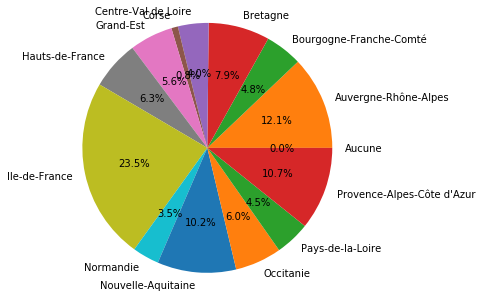

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.pie(region_stock.values(), labels = region_names, autopct='%1.1f%%')
plt.axis('equal')
plt.savefig('Pie')

## Transactions

In [50]:
transactions_df.head()

day  commercial_year store_code        ticket_id     client_id_2  \
174 2015-06-18         201525.0       B750  22707/000112774               X   
175 2015-06-18         201525.0       B750  22707/000112775  461:0000005900   
176 2015-06-18         201525.0       B750  22707/000112775  461:0000005900   
177 2015-06-18         201525.0       B750  22707/000112775  461:0000005900   
178 2015-06-18         201525.0       B750  22707/000112775  461:0000005900   

     ticket_line_number promo_code discount_code returning_code  \
174                 1.0      P3B5E           XXX            XXX   
175                 1.0         PB           OPR            XXX   
176                 2.0         PB           OPR            XXX   
177                 3.0         PB           OPR            XXX   
178                 4.0         PB           OPR            XXX   

    collection_code    ...    unit_sold price_theoric price_net_no_taxes  \
174             B5E    ...          1.0          55.0              27.50   
175             B5E    ...          1.0          79.0              52.67   
176             B5E    ...          1.0          99.0              57.75   
177             B5E    ...          1.0          80.0              33.33   
178             B5E    ...          1.0          69.0              40.25   

     price_net   cost  margin  cashier_discount  unit_price  unit_cost  \
174       33.0  10.35   17.15               0.0        55.0      10.35   
175       63.2  18.48   34.19              15.8        79.0      18.48   
176       69.3  26.22   31.53              29.7        99.0      26.22   
177       40.0  20.55   12.78              40.0        80.0      20.55   
178       48.3  17.02   23.23              20.7        69.0      17.02   

     discount  
174        40  
175         0  
176         0  
177         0  
178         0  

[5 rows x 23 columns]

Check with daily sales and margin pattern

In [51]:
# group transactions by day to check daily sales and margin
df = transactions_df.groupby("day").agg({'unit_sold':'sum','margin':'sum'})

In [52]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,9),dpi=1024)
ts = df['unit_sold']
plt.plot(ts)
plt.title("daily sales")
plt.show()

In [53]:
fig = plt.figure(figsize=(16,9),dpi=1024)
ts = df['margin']
plt.plot(ts)
plt.title("daily margin")
plt.show()

In daily sales, we observe a peak in sales every half a year and a decreasing trend.

In [54]:
# calcaulate the actual price per unit
transactions_df['actual_price'] = transactions_df['price_net']/transactions_df['unit_sold']

In [55]:
# combine the transaction data with region
region = pd.read_csv("Stores_new_regions.csv")
region = region.drop("Unnamed: 0",axis=1)
region = region.dropna()

In [56]:
# merge the two dataset by "store_code"
merged = transactions_df.merge(region,on='store_code',how='left')

In [57]:
merged.head()

day  commercial_year store_code        ticket_id     client_id_2  \
0 2015-06-18         201525.0       B750  22707/000112774               X   
1 2015-06-18         201525.0       B750  22707/000112775  461:0000005900   
2 2015-06-18         201525.0       B750  22707/000112775  461:0000005900   
3 2015-06-18         201525.0       B750  22707/000112775  461:0000005900   
4 2015-06-18         201525.0       B750  22707/000112775  461:0000005900   

   ticket_line_number promo_code discount_code returning_code collection_code  \
0                 1.0      P3B5E           XXX            XXX             B5E   
1                 1.0         PB           OPR            XXX             B5E   
2                 2.0         PB           OPR            XXX             B5E   
3                 3.0         PB           OPR            XXX             B5E   
4                 4.0         PB           OPR            XXX             B5E   

        ...        unit_price unit_cost discount  actual_price  \
0       ...              55.0     10.35       40          33.0   
1       ...              79.0     18.48        0          63.2   
2       ...              99.0     26.22        0          69.3   
3       ...              80.0     20.55        0          40.0   
4       ...              69.0     17.02        0          48.3   

            location  business_network  total_surface  sales_surface  \
0  Centre Commercial        Succursale          102.0           92.0   
1  Centre Commercial        Succursale          102.0           92.0   
2  Centre Commercial        Succursale          102.0           92.0   
3  Centre Commercial        Succursale          102.0           92.0   
4  Centre Commercial        Succursale          102.0           92.0   

   stock_surface  Nouvelle_Région  
0           10.0    Ile-de-France  
1           10.0    Ile-de-France  
2           10.0    Ile-de-France  
3           10.0    Ile-de-France  
4           10.0    Ile-de-France  

[5 rows x 30 columns]

### Regional sales

In [58]:
# the rest has no na
merged2 = merged.dropna()

In [59]:
# group the sales data by region
region_sale = merged2.groupby('Nouvelle_Région').agg({'unit_sold':'sum','margin':'sum','cost':'sum'}).reset_index()

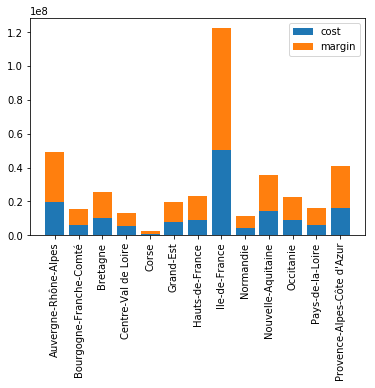

In [60]:
# A stacked barplot to compare the regional margin and cost
ind = np.arange(13)
p1 = plt.bar(ind, region_sale['cost'])
p2 = plt.bar(ind,region_sale['margin'],bottom=region_sale['cost'])
plt.xticks(ind, region_sale['Nouvelle_Région'],rotation=90)
plt.legend((p1[0], p2[0]), ('cost', 'margin'))
plt.show()

### Weekly demand elasticity with price

In [61]:
week = transactions_df.groupby('commercial_year').agg({'unit_sold':'sum','actual_price':'mean','margin':'sum'}).reset_index()

In [62]:
week.head()

commercial_year  unit_sold  actual_price      margin
0         201525.0    79826.0     47.766450  1835342.06
1         201526.0   191610.0     44.425717  3899902.88
2         201527.0   138174.0     43.766006  2697521.59
3         201528.0   119579.0     39.368566  1798362.94
4         201529.0    87663.0     36.433770  1082202.56

Text(0.5,0,'actual price')

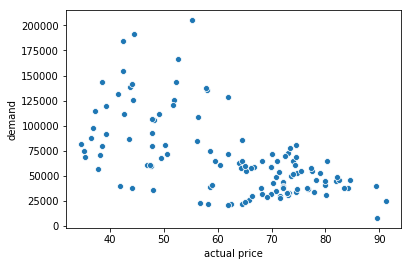

In [63]:
import seaborn as sns
# the demand change with price, we observe an exponential decrease
ax = sns.scatterplot('actual_price','unit_sold',data=week)
plt.ylabel("demand")
plt.xlabel("actual price")

In [64]:
week['log_demand'] = np.log(week['unit_sold'])

In [65]:
week.head()

commercial_year  unit_sold  actual_price      margin  log_demand
0         201525.0    79826.0     47.766450  1835342.06   11.287605
1         201526.0   191610.0     44.425717  3899902.88   12.163217
2         201527.0   138174.0     43.766006  2697521.59   11.836269
3         201528.0   119579.0     39.368566  1798362.94   11.691733
4         201529.0    87663.0     36.433770  1082202.56   11.381255

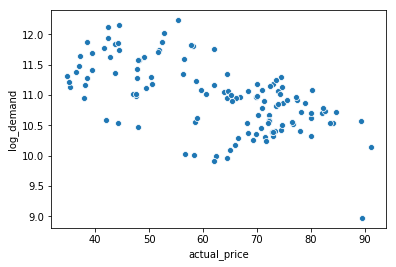

In [66]:
ax = sns.scatterplot('actual_price','log_demand',data=week)

After applying the logarithm, the data points show a linear trend, so demand curve may have an exponential trend.

In [67]:
# we can do a linear regression to solve the elasticity curve: log(demand) = a*price + b, demand = exp(a*price+b)
x = week['actual_price'].as_matrix()
y = week['log_demand'].as_matrix()
# linear regression of log(demand) and price
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print("p-value:{}".format(p_value))
print("slope:{}".format(slope))
print("intercept:{}".format(intercept))

C:\Users\Jithendra Sai V\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Jithendra Sai V\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


p-value:4.256224565405175e-13
slope:-0.023030306157818925
intercept:12.404085751200121


Text(0,0.5,'demand')

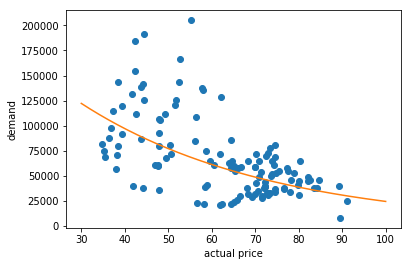

In [68]:
# plot the curve
def fun(x,a,b):
    y = np.exp(a*x+b)
    return y

xx = np.linspace(30,100,1000)
yy = fun(xx,slope,intercept)
plt.plot(x,week['unit_sold'],'o', xx, yy)
plt.xlabel("actual price")
plt.ylabel("demand")

We can estimate the demand per sku per discount，given propotion of the sku in total week sales.

In [69]:
### Sales by product type

In [70]:
# replace the collection_code with the result of product clustering
merged2['collection_code'] = merged2.collection_code.replace(['99P', 'B0E', 'B5E', 'B7H', 'Z6H', 'B3H', 'B4H', 'B2H','nan'],'1')
merged2['collection_code'] = merged2.collection_code.replace(['B3E','B5H', 'B6E', 'B1H', 'B0H', 'B4E', 'B1E'],'2')
merged2['collection_code'] = merged2.collection_code.replace(['Z5H', '99C','B2E', 'B7E', 'B6H', 'Z7E', 'Z6E', '50E', 'Z5E'],'3')

C:\Users\Jithendra Sai V\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Jithendra Sai V\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jithendra Sai V\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [71]:
merged2['collection_code'].value_counts()

2      3658066
3      3486840
1      1192077
A0H          2
A7H          1
Name: collection_code, dtype: int64

In [72]:
# delete records with A0H and A7H
merged2['collection_code'] = merged2['collection_code'].replace('A0H',np.nan)
merged2['collection_code'] = merged2['collection_code'].replace('A7H',np.nan)
merged2 = merged2.dropna()

C:\Users\Jithendra Sai V\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Jithendra Sai V\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [73]:
# group the data by week
week_df = merged2.groupby(['collection_code','commercial_year']).agg({'unit_sold':'sum','price_theoric':'mean','margin':'mean'}).reset_index()

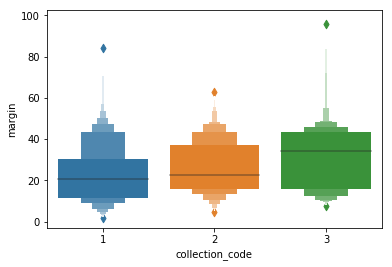

In [74]:
# boxplot of margin by collection code
sns.boxenplot(x="collection_code",y="margin", data=week_df)

* Margin ranking: Cluster 3 > Cluster 2 > Cluster 1
* The mean margin for cluster 3 is greater than that of clusters 2 and 1, indicating high margin collections.
* Products in this cluster should be targeted towards  customers while selling

In [75]:
collection_region = merged2.groupby(['Nouvelle_Région','collection_code']).agg({'unit_sold':'count'}).reset_index()

In [76]:
collection_region = collection_region.pivot(index='Nouvelle_Région',columns='collection_code',values='unit_sold')
collection_region

collection_code                  1        2        3
Nouvelle_Région                                     
Auvergne-Rhône-Alpes        141066   462218   421165
Bourgogne-Franche-Comté      43227   141637   134654
Bretagne                     80908   235756   221095
Centre-Val de Loire          37412   124591   113663
Corse                         7952    24416    22153
Grand-Est                    54783   185594   168511
Hauts-de-France              66320   217128   203900
Ile-de-France               387424  1111142  1086127
Normandie                    32413   100487    99224
Nouvelle-Aquitaine          109973   335380   302059
Occitanie                    62942   196611   213951
Pays-de-la-Loire             44053   142691   140390
Provence-Alpes-Côte d'Azur  123604   380415   359948

* Stores with large catchment areas and high turnovers need to stock collections in clusters 3 and 2 to increase profits
* IIe-de-france, Auvergne-Rhône-Alpes, Provence-Alpes-Côte d’Azur are the most profitable régions, where high margin products can be targeted toward customers

## Product description

In [77]:
product_df.head()

collection_code  pdt_code     color         pdt_desc  major_color  \
0             99P  8201399X         .  150 PM SACS E99         99.0   
1             99P  8201299X         .  200 MM SACS E99         99.0   
2             99P  8200599X         .  25 ALBUMS VALEN         99.0   
3             99P  8391299X         .  4 PRT.VISU EBEN         99.0   
4             B0E  3O80707U  NOIR UNI            AARON          7.0   

  color_code tissu_code tissu_color_code tissu category_code    ...     \
0          X        NaN              NaN   NaN            XX    ...      
1          X        NaN              NaN   NaN            XX    ...      
2          X        NaN              NaN   NaN            XX    ...      
3          X        NaN              NaN   NaN            XX    ...      
4          U        NaN              NaN   NaN           MAN    ...      

  price_range_code    price_range seasonality_code seasonality  \
0              XXX            NaN              XXX         NaN   
1              XXX            NaN              XXX         NaN   
2              XXX            NaN              XXX         NaN   
3              XXX            NaN              XXX         NaN   
4              MOY  MOYENNE GAMME              LON      LONGUE   

  pdt_typologie_code pdt_typologie size            sku size_info size_grid  
0                NaN           NaN  T.U  P998201399X01       1.0         D  
1                NaN           NaN  T.U  P998201299X01       1.0         D  
2                NaN           NaN  T.U  P998200599X01       1.0         D  
3                NaN           NaN  T.U  P998391299X01       1.0         D  
4                ESS     ESSENTIEL   34  EB03O80707U01       1.0         A  

[5 rows x 42 columns]

In [78]:
product_df.iloc[0]

collection_code                     99P
pdt_code                       8201399X
color                                 .
pdt_desc                150 PM SACS E99
major_color                          99
color_code                            X
tissu_code                          NaN
tissu_color_code                    NaN
tissu                               NaN
category_code                        XX
category              COMMUNICATION PUB
family_code                         PUB
family                        PUBLICITE
subfamily_code                       XX
subfamily                             .
shape_code                           XX
shape                                 .
sleeve_code                         AUT
sleeve                              NaN
collar_code                         AUT
collar                              NaN
theme_code                          ZZZ
theme                               NaN
tissu2_code                         XXX
tissu2                              NaN


Change collection code and price range code into quantitaive variables 

In [79]:
product_df['collection_code'] = product_df.collection_code.replace('99P',1)
product_df['collection_code'] = product_df.collection_code.replace('B0E',2)
product_df['collection_code'] = product_df.collection_code.replace('B5E',3)
product_df['collection_code'] = product_df.collection_code.replace('B7H',4)
product_df['collection_code'] = product_df.collection_code.replace('Z6H',5)
product_df['collection_code'] = product_df.collection_code.replace('B3H',6)
product_df['collection_code'] = product_df.collection_code.replace('B4H',7)
product_df['collection_code'] = product_df.collection_code.replace('B2H',8)
product_df['collection_code'] = product_df.collection_code.replace('B3E',9)
product_df['collection_code'] = product_df.collection_code.replace('B5H',10)
product_df['collection_code'] = product_df.collection_code.replace('B6E',11)
product_df['collection_code'] = product_df.collection_code.replace('B1H',12)
product_df['collection_code'] = product_df.collection_code.replace('B0H',13)
product_df['collection_code'] = product_df.collection_code.replace('B4E',14)
product_df['collection_code'] = product_df.collection_code.replace('B1E',15)
product_df['collection_code'] = product_df.collection_code.replace('Z5H',16)
product_df['collection_code'] = product_df.collection_code.replace('99C',17)
product_df['collection_code'] = product_df.collection_code.replace('B2E',18)
product_df['collection_code'] = product_df.collection_code.replace('B7E',19)
product_df['collection_code'] = product_df.collection_code.replace('B6H',20)
product_df['collection_code'] = product_df.collection_code.replace('Z7E',21)
product_df['collection_code'] = product_df.collection_code.replace('Z6E',22)
product_df['collection_code'] = product_df.collection_code.replace('50E',23)
product_df['collection_code'] = product_df.collection_code.replace('Z5E',24)
product_df['collection_code'] = product_df.collection_code.replace(np.nan, 0)

In [80]:
product_df['price_range_code'] = product_df.price_range_code.replace('XXX',1)
product_df['price_range_code'] = product_df.price_range_code.replace('MOY',2)
product_df['price_range_code'] = product_df.price_range_code.replace('ENT',3)
product_df['price_range_code'] = product_df.price_range_code.replace('HAU',4)
product_df['price_range_code'] = product_df.price_range_code.replace('CDG',5)
product_df['price_range_code'] = product_df.price_range_code.replace('BAS',6)
product_df['price_range_code'] = product_df.price_range_code.replace('IMA',7)
product_df['price_range_code'] = product_df.price_range_code.replace(np.nan, 0)

input them into a vector and run kmeans clustersing, plot clusters 

In [81]:
f1 = product_df['collection_code'].values
#f2 = product_df['color_code'].values
f3 = product_df['price_range_code'].values
#f4 = product_df['seasonality_code'].values
X=np.array(list(zip(f1,f3)))
X.shape

(130055, 2)

In [82]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5).fit(X)
y_kmeans = kmeans.predict(X)
centers = kmeans.cluster_centers_

In [83]:
print(centers)

[[11.0927604   2.65242274]
 [19.81518117  2.65631906]
 [ 3.02660203  2.6003585 ]
 [ 7.55288098  2.6629009 ]
 [14.1165781   2.52677543]]


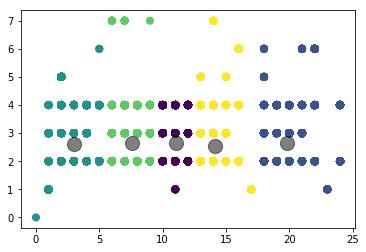

In [84]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## End of the assignment

### Prepare the final dataset

In [88]:
# Load the merged file (transactions + stores characteristic + product description)

In [86]:
merged_2 = pd.read_csv("merged2.csv")

In [87]:
# Replace the collection code

In [58]:
merged_2['collection_code'] = merged_2.collection_code.replace(['99P', 'B0E', 'B5E', 'B7H', 'Z6H', 'B3H', 'B4H', 'B2H','nan'],'1')

In [59]:
merged_2['collection_code'] = merged_2.collection_code.replace(['B3E','B5H', 'B6E', 'B1H', 'B0H', 'B4E', 'B1E'],'2')

In [60]:
merged_2['collection_code'] = merged_2.collection_code.replace(['Z5H', '99C','B2E', 'B7E', 'B6H', 'Z7E', 'Z6E', '50E', 'Z5E'],'3')

In [429]:
#merged_2.iloc[0]

In [ ]:
# Merge the merged file with the CRM dataset (we now have all the data except the 2 stock datasets)

In [61]:
final = merged_2.merge(new,how='left',on="client_id_2")

In [62]:
final.head()

Unnamed: 0         day  commercial_year store_code_x        ticket_id  \
0           0  2015-06-18         201525.0         B750  22707/000112774   
1           1  2015-06-18         201525.0         B750  22707/000112775   
2           2  2015-06-18         201525.0         B750  22707/000112775   
3           3  2015-06-18         201525.0         B750  22707/000112775   
4           4  2015-06-18         201525.0         B750  22707/000112775   

      client_id_2  ticket_line_number promo_code discount_code returning_code  \
0               X                 1.0      P3B5E           XXX            XXX   
1  461:0000005900                 1.0         PB           OPR            XXX   
2  461:0000005900                 2.0         PB           OPR            XXX   
3  461:0000005900                 3.0         PB           OPR            XXX   
4  461:0000005900                 4.0         PB           OPR            XXX   

  ...            location business_network total_surface sales_surface  \
0 ...   Centre Commercial       Succursale         102.0          92.0   
1 ...   Centre Commercial       Succursale         102.0          92.0   
2 ...   Centre Commercial       Succursale         102.0          92.0   
3 ...   Centre Commercial       Succursale         102.0          92.0   
4 ...   Centre Commercial       Succursale         102.0          92.0   

   stock_surface  Nouvelle_Région  client_id_1  store_code_y  segmentation  \
0           10.0    Ile-de-France          NaN           NaN           NaN   
1           10.0    Ile-de-France          NaN           NaN           NaN   
2           10.0    Ile-de-France          NaN           NaN           NaN   
3           10.0    Ile-de-France          NaN           NaN           NaN   
4           10.0    Ile-de-France          NaN           NaN           NaN   

   age  
0  NaN  
1  NaN  
2  NaN  
3  NaN  
4  NaN  

[5 rows x 35 columns]

In [3]:
#final.iloc[0]

In [64]:
# Drop the columns that won't be used in the model
final = final.drop(["day",    
            "commercial_year",
            "store_code_x",
            "ticket_id",
            "client_id_2",
            "ticket_line_number",
            "promo_code",
            "discount_code",
            "returning_code",
            "pdt_code", 
            "size",
            "sku",
            "business_network",
            "client_id_1",
            "store_code_y"], axis = 1)

In [79]:
final.head()

Unnamed: 0  collection_code  unit_sold  price_theoric  price_net_no_taxes  \
0           0                1        1.0           55.0               27.50   
1           1                1        1.0           79.0               52.67   
2           2                1        1.0           99.0               57.75   
3           3                1        1.0           80.0               33.33   
4           4                1        1.0           69.0               40.25   

   price_net   cost  margin  cashier_discount  unit_price  unit_cost  \
0       33.0  10.35   17.15               0.0        55.0      10.35   
1       63.2  18.48   34.19              15.8        79.0      18.48   
2       69.3  26.22   31.53              29.7        99.0      26.22   
3       40.0  20.55   12.78              40.0        80.0      20.55   
4       48.3  17.02   23.23              20.7        69.0      17.02   

   discount  actual_price  location  total_surface  sales_surface  \
0        40          33.0         1          102.0           92.0   
1         0          63.2         1          102.0           92.0   
2         0          69.3         1          102.0           92.0   
3         0          40.0         1          102.0           92.0   
4         0          48.3         1          102.0           92.0   

   stock_surface  Nouvelle_Région  segmentation  age  
0           10.0                0             0  NaN  
1           10.0                0             0  NaN  
2           10.0                0             0  NaN  
3           10.0                0             0  NaN  
4           10.0                0             0  NaN

In [67]:
# Convert categorical variables into dummy variables

In [68]:
final.location = pd.get_dummies(final.location)

In [69]:
final.Nouvelle_Région = pd.get_dummies(final.Nouvelle_Région)

In [70]:
final.collection_code = pd.get_dummies(final.collection_code)

In [75]:
final.segmentation = pd.get_dummies(final.segmentation)

In [ ]:
# Drop the rows with missing values

In [80]:
final = final.dropna()

In [ ]:
# Length of the dataset without the missing values

In [106]:
len(final)

5777962

### Linear regression model

In [ ]:
# Apply a linear regression

In [71]:
from sklearn.linear_model import LinearRegression

In [82]:
X = final.drop("unit_sold",axis=1).values

y = final['unit_sold'].values()

In [ ]:
# Training the model

In [107]:
from sklearn.model_selection import train_test_split

In [108]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

In [109]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.7510606842224723

In [113]:
np.shape(X_train)

(3871234, 19)

In [ ]:
# Testing the model

In [110]:
reg.score(X_test, y_test)

0.7315267005833251

In [112]:
np.shape(X_test)

(1906728, 19)

In [105]:
# Obtain the coefficient list
l = list(final.columns)
l.remove('unit_sold')
for i,n in enumerate(l):
    print(n,' ',reg.coef_[i])

Unnamed: 0   -6.089750085969715e-12
collection_code   7.51724139001558e-05
price_theoric   0.018670087929393685
price_net_no_taxes   0.03043409705029266
price_net   0.006604191441985211
cost   -0.07646085881303846
margin   -0.03453479981082992
cashier_discount   1.4815120541696733e-05
unit_price   -0.018686868988138605
unit_cost   0.0419418320434124
discount   1.06928899268099e-05
actual_price   -0.0031766898204219486
location   -1.1240619637326694e-05
total_surface   -0.009678657585815908
sales_surface   0.009678595880626976
stock_surface   0.009678669167047113
Nouvelle_Région   2.1236139296406066e-05
segmentation   0.00014153208044534742
age   -1.0825502913133067e-06
